In [257]:
from pathlib import Path
import numpy as np
from xgboost import XGBClassifier
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
RANDOM_SEED = 6

In [258]:
features_df = pd.read_csv("training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv("training_set_labels.csv", 
    index_col="respondent_id"
)

In [259]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

In [260]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [261]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['xyz_concern' 'xyz_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_xyz' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_xyz_vacc_effective' 'opinion_xyz_risk'
 'opinion_xyz_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [262]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))
])
preprocessor = ColumnTransformer(
    transformers = [("numeric", numeric_preprocessing_steps, numeric_cols)],
    remainder = "drop"
)

In [285]:
estimators = MultiOutputClassifier(
    estimator= LogisticRegression(penalty="l2")
)

In [286]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [287]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.25,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [288]:
full_pipeline.fit(X_train, y_train)
preds = full_pipeline.predict_proba(X_eval)

In [289]:
y_preds = pd.DataFrame(
    {
        "xyz_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,xyz_vaccine,seasonal_vaccine
respondent_id,,
3178,0.204735,0.791737
26690,0.007739,0.163718
17271,0.025603,0.031717
25216,0.644688,0.901351
5061,0.566680,0.816467


In [290]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.3f}"
    )

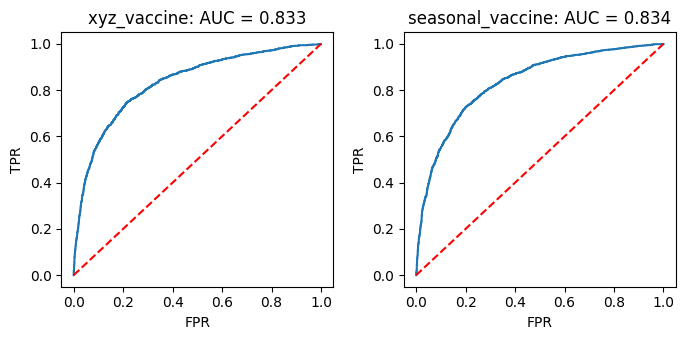

In [291]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['xyz_vaccine'], 
    y_preds['xyz_vaccine'], 
    'xyz_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [292]:
roc_auc_score(y_eval, y_preds)

0.8337403533739788

In [293]:
full_pipeline.fit(features_df, labels_df) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  array(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherin...
       'doctor_recc_xyz', 'doctor_recc_seasonal', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc',
       'household_adults', 'household_children'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression()))])

In [294]:
test_features_df = pd.read_csv("test_set_features.csv", 
                               index_col="respondent_id")

In [295]:
test_probas = full_pipeline.predict_proba(test_features_df)

In [296]:
submission_df = pd.read_csv("submission.csv", 
                            index_col="respondent_id")

In [297]:
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
submission_df["xyz_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,xyz_vaccine,seasonal_vaccine
respondent_id,,
26707,0.126922,0.424427
26708,0.055253,0.070829
26709,0.367187,0.634061
26710,0.464090,0.803904
26711,0.287824,0.633329


In [298]:
submission_df.to_csv('submission.csv', index=True)